In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
import pickle
import types
import io

## Process MIMIC data for regression

### With imputation, dropping columns with NaNs, and scaling

In [2]:
#TODO: Removed earlynotes for now to avoid temporal issues and embedding issues.
# Load the temporal data

def process_mimic_data():
    df_features = pd.read_csv('data/processed/features.csv')

    # List of temporal features to aggregate
    temporal_features = [
        'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc', 'spo2',
        'aniongap', 'albumin', 'bands', 'bicarbonate', 'bilirubin', 'creatinine',
        'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'platelet',
        'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'
    ]

    # Aggregate temporal data by computing summary statistics for each 'hadm_id'
    temporal_aggregated = df_features.groupby('hadm_id').agg({feature: ['mean', 'max', 'min'] for feature in temporal_features}).reset_index()

    # Flatten the multi-level columns after aggregation
    temporal_aggregated.columns = ['_'.join(col).strip() if col[1] else col[0] for col in temporal_aggregated.columns.values]

    # Load non-temporal data
    df_demo = pd.read_csv('data/processed/demo.csv')
    df_labels_icd = pd.read_csv('data/processed/labels_icd.csv')
    df_los = pd.read_csv('data/processed/los.csv')

    # Merge datasets on 'hadm_id'
    df_combined = df_demo.merge(temporal_aggregated, on='hadm_id', how='inner') \
                        .merge(df_labels_icd, on='hadm_id', how='inner') \
                        .merge(df_los, on='hadm_id', how='inner') 

    ######################## Remove columns with NaNs ########################
    # Calculate the number of NaNs in each column
    nan_counts = df_combined.isnull().sum()

    # Columns with NaNs
    columns_with_nans = nan_counts[nan_counts > 0].index.tolist()

    # Calculate the percentage of NaNs in each column
    nan_percentage = (nan_counts / len(df_combined)) * 100

    # Combine the counts and percentages into a DataFrame for better readability
    nan_summary = pd.DataFrame({'NaN Count': nan_counts, 'NaN Percentage': nan_percentage})

    # Print the number of columns before removing
    print(f"Number of columns before removing: {df_combined.shape[1]}")

    # Identify columns to remove where NaN percentage is greater than 50%
    columns_to_remove = nan_summary[nan_summary['NaN Percentage'] > 50].index.tolist()

    print("Columns with NaNs that will be kept", nan_summary[(nan_summary['NaN Percentage'] < 50) & (nan_summary['NaN Count'] != 0)].index.tolist())

    # Print the columns that will be removed
    print("Columns to be removed (NaN > 50%):", columns_to_remove)

    # Remove the identified columns
    df_combined = df_combined.drop(columns=columns_to_remove)

    # Print the number of columns after removing
    print(f"Number of columns after removing: {df_combined.shape[1]}")

    ######################## Create binary demographic variables before encoding ########################
    df_combined['is_white'] = df_combined['ethnicity'].str.startswith('WHITE').astype(int) #1 for white, 0 for non-white
    df_combined['gender_binary'] = (df_combined['gender'] == 'F').astype(int)  # 1 for female, 0 for male

    # Drop original demographic columns since we have binary versions
    df_combined = df_combined.drop(columns=['ethnicity', 'gender'])
    
    # Identify numerical features (excluding target, hadm_id, and demographic variables)
    numerical_features = df_combined.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_features = [col for col in numerical_features 
                         if col not in ['los', 'hadm_id', 'is_white', 'gender_binary']]
    
    X_train, X_test= train_test_split(df_combined, test_size=0.3, random_state=42)
    # Scale numerical features just using the train set
    scaler = StandardScaler()
    scaler.fit(X_train[numerical_features])
    df_combined[numerical_features] = scaler.transform(df_combined[numerical_features])
    
    # Get non-numeric columns for one-hot encoding (excluding already processed demographic features)
    non_numeric_columns = df_combined.select_dtypes(include=['object', 'category']).columns
    
    # Apply one-hot encoding to remaining categorical variables
    df_combined_encoded = pd.get_dummies(df_combined, columns=non_numeric_columns, dtype=int)
    
    print("Imputing missing values")
    # Identify columns with NaNs that are not removed
    columns_with_nans_to_impute = [col for col in columns_with_nans 
                                  if col not in columns_to_remove]
    
    # Perform KNN imputation
    imputer = KNNImputer(n_neighbors=5)
    df_combined_encoded[columns_with_nans_to_impute] = imputer.fit_transform(
        df_combined_encoded[columns_with_nans_to_impute]
    )
    print("Imputing missing values done")
    
    # Define target variable and scale it using train set
    #y_scaler = MinMaxScaler(feature_range=(0, 1))
    y = df_combined_encoded['los']
    y_train, y_test = train_test_split(y, test_size=0.3, random_state=42)

    # Apply log transformation
    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # Calculate mean and std from training portion only
    y_train_mean = np.mean(np.log1p(y_train_log))
    y_train_std = np.std(np.log1p(y_train_log))

    # Standardize using training statistics
    y_train_standardized = (y_train_log - y_train_mean) / y_train_std
    y_test_standardized = (y_test_log - y_train_mean) / y_train_std

    # Recombine to preserve original order
    y = pd.concat([y_train_standardized, y_test_standardized]).sort_index()

    
    # Create two versions of features
    # 1. All features including demographic variables
    X_all = df_combined_encoded.drop(columns=['hadm_id', 'los'])
    
    # 2. Features without sensitive attributes
    X_without_sensitive = X_all.drop(columns=['gender_binary', 'is_white'])
    
    print(f"Shape of X_all: {X_all.shape}")
    print(f"Shape of X_without_sensitive: {X_without_sensitive.shape}")
    
    return X_all, X_without_sensitive, y

X_all, X_without_sensitive, y = process_mimic_data()

Number of columns before removing: 106
Columns with NaNs that will be kept ['aniongap_mean', 'aniongap_max', 'aniongap_min', 'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_min', 'creatinine_mean', 'creatinine_max', 'creatinine_min', 'chloride_mean', 'chloride_max', 'chloride_min', 'glucose_mean', 'glucose_max', 'glucose_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'hemoglobin_mean', 'hemoglobin_max', 'hemoglobin_min', 'platelet_mean', 'platelet_max', 'platelet_min', 'potassium_mean', 'potassium_max', 'potassium_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'pt_mean', 'pt_max', 'pt_min', 'sodium_mean', 'sodium_max', 'sodium_min', 'bun_mean', 'bun_max', 'bun_min', 'wbc_mean', 'wbc_max', 'wbc_min']
Columns to be removed (NaN > 50%): ['heartrate_mean', 'heartrate_max', 'heartrate_min', 'sysbp_mean', 'sysbp_max', 'sysbp_min', 'diasbp_mean', 'diasbp_max', 'diasbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'resprate_mean', 'resprate_max',

<Axes: >

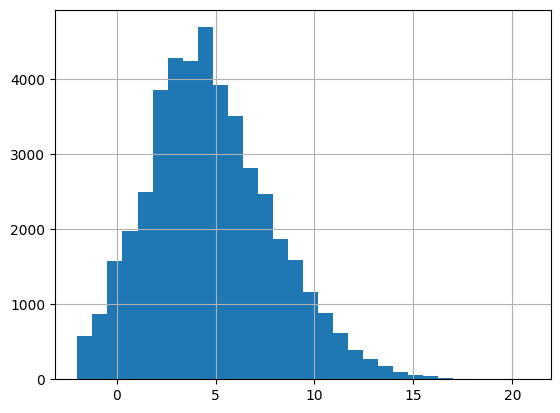

In [3]:
y.hist(bins=30)

In [4]:
# Define a neural network model with batch normalization and dropout
# Neural Network Model Definition
class DeeperNNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=512, hidden_dim2=256, hidden_dim3=64, dropout_prob=0.2):
        super(DeeperNNWithBatchNorm, self).__init__()
        # Define layers with batch normalization and dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)

        self.fc4 = nn.Linear(hidden_dim3, 1)  # Output layer for regression task

    def forward(self, x):
        # Forward pass through layers with batch normalization, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Function to train the neural network model with early stopping
def train_neural_network_model(X_train, y_train, X_test, y_test, input_dim, lr=0.001, epochs=1000, hidden_dim1=512, hidden_dim2=256, hidden_dim3=64, dropout_prob=0.2, patience=10):
    # Initialize the neural network model with specified dimensions and dropout
    model = DeeperNNWithBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_prob)
    criterion = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for better convergence
    
    # Convert training and test data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(pd.to_numeric(y_test).values, dtype=torch.float32).view(-1, 1)
    
    # Store the loss values for visualization
    train_loss_values = []
    test_loss_values = []

    # Early stopping variables
    best_test_loss = float('inf')  # Best test loss observed
    patience_counter = 0  # Number of epochs without improvement
    
    # Training loop with early stopping
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Zero gradients
        outputs = model(X_train_tensor)  # Forward pass
        train_loss = criterion(outputs, y_train_tensor)  # Compute training loss
        train_loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights

        # Save training loss for each epoch
        train_loss_values.append(train_loss.item())

        # Evaluate on the test set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No need to compute gradients for test set
            test_outputs = model(X_test_tensor)  # Forward pass on test set
            test_loss = criterion(test_outputs, y_test_tensor)  # Compute test loss
            test_loss_values.append(test_loss.item())

        # Early stopping: Check if test loss improved
        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()  # Update best test loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter if no improvement

        # Print loss every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
        
        # Check if early stopping criteria are met
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}, Test Loss: {test_loss.item():.4f}')
            break

    # Plot the training and test loss values
    plt.plot(range(len(train_loss_values)), train_loss_values, label='Train Loss')
    plt.plot(range(len(test_loss_values)), test_loss_values, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss per Epoch')
    plt.legend()
    plt.show()

    return model

In [5]:
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_tensor).squeeze()
    return predictions.numpy()

# Function to evaluate the neural network regression model
def evaluate_model_regression(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_model(model, X_train)
    y_test_pred = predict_model(model, X_test)

    # Calculate regression metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Plot predictions vs true values for test data
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predictions vs True Values - Test Data ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
    plt.show()

    # Print regression metrics
    print(f"{model_name} - Training MSE: {train_mse:.4f}")
    print(f"{model_name} - Test MSE: {test_mse:.4f}")

In [6]:
# Function to train and evaluate models using the MIMIC dataset
def train_and_evaluate_model():
    # Step 1: Process and prepare the MIMIC data
    X_all, X_without_sensitive, y = process_mimic_data()

    # Step 2: Split the data into training and testing sets for both feature sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)
    X_train_h0, X_test_h0 = train_test_split(X_without_sensitive, test_size=0.3, random_state=42)

    print("Running MIMIC regression task")

    # Step 3: Train and evaluate model with all features (HP)
    print("Training and evaluating model with all features (HP)...")
    model_hp = train_neural_network_model(
        X_train_hp, y_train, X_test_hp, y_test, 
        input_dim=X_train_hp.shape[1], 
        lr=0.001, 
        epochs=400, 
        patience=20
    )
    evaluate_model_regression(model_hp, X_train_hp, X_test_hp, y_train, y_test, "MIMIC_h_p")

    # Step 4: Train and evaluate model excluding sensitive attributes (H0)
    print("\nTraining and evaluating model excluding sensitive attributes (H0)...")
    model_h0 = train_neural_network_model(
        X_train_h0, y_train, X_test_h0, y_test, 
        input_dim=X_train_h0.shape[1], 
        lr=0.001, 
        epochs=400, 
        patience=20
    )
    evaluate_model_regression(model_h0, X_train_h0, X_test_h0, y_train, y_test, "MIMIC_h_0")
    
    # Step 5: Return the necessary objects
    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

In [7]:
def create_gender_race_filters(X_test):
    """
    Create filters for the four groups based on combinations of gender and race.
    For MIMIC: gender_binary (1=female, 0=male) and is_white (1=white, 0=non-white)
    """
    filters = {}

    # Female + White
    filters['Female, White'] = (X_test['gender_binary'] == 1) & (X_test['is_white'] == 1)
    
    # Female + Non-White
    filters['Female, NonWhite'] = (X_test['gender_binary'] == 1) & (X_test['is_white'] == 0)
    
    # Male + White
    filters['Male, White'] = (X_test['gender_binary'] == 0) & (X_test['is_white'] == 1)
    
    # Male + Non-White
    filters['Male, NonWhite'] = (X_test['gender_binary'] == 0) & (X_test['is_white'] == 0)

    return filters


def evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific group using a custom cost function.
    Filter predictions and true values using group indices (e.g., gender + race).
    """
    y_group_pred = y_preds[group_indices]
    y_group_val = y_val[group_indices]

    # Compute element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_group_val, y_group_pred)])

    total_loss = np.mean(individual_losses)
    
    return total_loss, y_group_pred, y_group_val


def evaluate_model_by_combined_groups(y_preds, y_val, filters, cost_function, comprehensiveness=False):
    """
    Evaluate predictions based on combined filters for gender and race.
    """
    group_losses = {}
    group_results = {}

    for group_name, group_indices in filters.items():
        group_loss, group_preds, group_true = evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness)
        group_losses[group_name] = group_loss
        group_results[group_name] = (group_preds, group_true)

    return group_losses, group_results


def compare_models_by_gender_race_filters(y_preds_hp, y_preds_h0, X_test, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare models' predictions by gender and race using filters for MIMIC dataset.
    """
    # Create filters for gender and race groups
    filters = create_gender_race_filters(X_test)

    # Evaluate total losses for both models
    total_loss_hp = np.mean([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)])
    total_loss_h0 = np.mean([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)])

    # Evaluate model h_p by group
    group_losses_hp, group_results_hp = evaluate_model_by_combined_groups(y_preds_hp, y_val_hp, filters, cost_function, comprehensiveness)

    # Evaluate model h_0 by group
    group_losses_h0, group_results_h0 = evaluate_model_by_combined_groups(y_preds_h0, y_val_h0, filters, cost_function, comprehensiveness)

    # Print results and calculate differences
    print("\nGroup-wise Performance Comparison:")
    print("-" * 80)
    print(f"{'Group':<20} {'Model h_p':<15} {'Model h_0':<15} {'Difference':<15}")
    print("-" * 80)
    
    for group_name in filters:
        loss_hp = group_losses_hp[group_name]
        loss_h0 = group_losses_h0[group_name]
        if comprehensiveness:
            loss_hp = -loss_hp
            loss_h0 = -loss_h0
        loss_diff = loss_h0 - loss_hp
        print(f"{group_name:<20} {loss_hp:>15.4f} {loss_h0:>15.4f} {loss_diff:>15.4f}")

    print("-" * 80)
    if comprehensiveness:
        total_loss_hp = -total_loss_hp
        total_loss_h0 = -total_loss_h0
    print(f"\nOverall Performance:")
    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference (h_0 - h_p): {total_loss_h0 - total_loss_hp:.4f}")

    return group_losses_hp, group_losses_h0

In [8]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given group (e.g., gender + race).
    """
    # Filter predictions and true values for the selected group
    y_preds_h0_filtered = y_preds_h0[group_indices]
    y_preds_hp_filtered = y_preds_hp[group_indices]
    y_vals_h0_filtered = y_val_h0[group_indices]
    y_vals_hp_filtered = y_val_hp[group_indices]

    if title == "Comprehensiveness":
        # Negate the losses for comprehensiveness
        individual_diff = np.array([cost_function(val_hp, pred_hp) - cost_function(val_h0, pred_h0)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])

    return individual_diff

# Apply consistent plot settings
plt.rcParams["font.family"] = "serif"  # Use serif font
plt.rcParams["font.size"] = 14  # Standard font size for plots
plt.rcParams["axes.labelsize"] = 14  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 16  # Font size for titles
plt.rcParams["legend.fontsize"] = 12  # Font size for legends
plt.rcParams["xtick.labelsize"] = 12  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 12  # Font size for y-tick labels

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for multiple groups using a custom element-wise cost function.
    Displays standard deviation in the upper left corner of each subplot.
    """
    # Create filters for the groups (assumes `create_gender_race_filters` is defined based on gender and race)
    filters = create_gender_race_filters(X_test)

    # Determine the number of rows and columns based on the number of groups for subplots
    num_filters = len(filters)
    num_cols = 2
    num_rows = int(np.ceil(num_filters / num_cols))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten()  # Flatten in case of multi-dimensional array

    # Adjust the cost function name for display purposes
    if cost_function.__name__ == 'squared_error':
        cost_function_name = 'Squared Error'
    else:
        cost_function_name = cost_function.__name__

    # Set the overall title for the entire figure, closer to the subplots
    fig.suptitle(f'{cost_function_name} {title} Difference per Subgroup', fontsize=20, y=0.98)

    for i, (group_name, group_indices) in enumerate(filters.items(), start=0):
        # Compute loss differences for each group
        group_loss_diff = individual_loss_difference(
            y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title
        )

        # Calculate standard deviation
        stddev = np.std(group_loss_diff)

        # Plot histogram for each group
        axes[i].hist(group_loss_diff, bins=30, alpha=0.7, color='#007791')  # Use a consistent color for histograms
        axes[i].set_title(f'{group_name}', fontsize=16)  # Title specific to each group
        axes[i].set_xlabel('Difference in Loss', fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)

        # Add standard deviation as a text label in the upper left corner of each subplot
        axes[i].text(0.05, 0.95, f'Stddev: {stddev:.4f}', transform=axes[i].transAxes,
                     fontsize=10, ha='left', va='top', color='black')  # Position text in the upper left corner

    # Remove any unused subplots (if filters count is less than number of subplots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and overall spacing to accommodate the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave some space for the top title
    plt.subplots_adjust(top=0.88)  # Adjust the top spacing to bring the title closer to subplots
    plt.show()

def plot_loss_difference_histogram_with_distributions(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference with overlaid Laplace and Gaussian distributions.
    """
    # Create filters for the groups
    filters = create_gender_race_filters(X_test)

    # Setup subplots
    num_filters = len(filters)
    num_cols = 2
    num_rows = int(np.ceil(num_filters / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten()

    # Format cost function name
    cost_function_name = 'Squared Error' if cost_function.__name__ == 'squared_error' else cost_function.__name__
    fig.suptitle(f'{cost_function_name} {title} Difference per Subgroup', fontsize=20, y=0.98)

    for i, (group_name, group_indices) in enumerate(filters.items(), start=0):
        # Compute loss differences
        group_loss_diff = individual_loss_difference(
            y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title
        )

        # Calculate statistics
        stddev = np.std(group_loss_diff)
        
        # Create histogram
        n, bins, patches = axes[i].hist(group_loss_diff, bins=30, density=True, 
                                      alpha=0.7, color='#007791', label='Data')
        
        # Fit Laplace distribution
        loc_laplace, scale_laplace = stats.laplace.fit(group_loss_diff)
        
        # Fit Gaussian distribution
        loc_gaussian, scale_gaussian = stats.norm.fit(group_loss_diff)
        
        # Generate points for PDF plots
        x = np.linspace(min(group_loss_diff), max(group_loss_diff), 100)
        laplace_pdf = stats.laplace.pdf(x, loc_laplace, scale_laplace)
        gaussian_pdf = stats.norm.pdf(x, loc_gaussian, scale_gaussian)
        
        # Plot distributions
        axes[i].plot(x, laplace_pdf, 'r-', lw=2, label='Laplace fit')
        axes[i].plot(x, gaussian_pdf, 'g--', lw=2, label='Gaussian fit')
        
        # Add labels and statistics
        axes[i].set_title(f'{group_name}\n' + 
                         f'Laplace: μ={loc_laplace:.4f}, b={scale_laplace:.4f}\n' +
                         f'Gaussian: μ={loc_gaussian:.4f}, σ={scale_gaussian:.4f}', 
                         fontsize=12)
        axes[i].set_xlabel('Difference in Loss', fontsize=14)
        axes[i].set_ylabel('Density', fontsize=14)
        
        # Add standard deviation text
        axes[i].text(0.05, 0.95, f'Stddev: {stddev:.4f}', 
                    transform=axes[i].transAxes,
                    fontsize=10, ha='left', va='top', color='black')
        
        # Add KS test statistics
        ks_laplace = stats.kstest(group_loss_diff, 'laplace', args=(loc_laplace, scale_laplace))
        ks_gaussian = stats.kstest(group_loss_diff, 'norm', args=(loc_gaussian, scale_gaussian))
        
        axes[i].legend(fontsize=10)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Increased top margin
    plt.subplots_adjust(top=0.82, hspace=0.7)  # Lowered the top position and increased vertical space between plots
    plt.show()
    
    return fig, axes

In [9]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

In [10]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions

In [11]:
def plot_group_losses(ks, hp_comp_list, h0_comp_list, hp_suff_list, h0_suff_list, group_name, cost_function, row_index):
    """
    Helper function to plot comprehensiveness and sufficiency losses for a specific group.
    """
    plt.subplot(4, 2, row_index)
    plt.plot(ks, hp_comp_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_comp_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Comprehensiveness')
    plt.legend()

    plt.subplot(4, 2, row_index + 4)  # Sufficiency plots in lower half
    plt.plot(ks, hp_suff_list, label=f'{group_name} $h_{{p}}$', marker='o')
    plt.plot(ks, h0_suff_list, label=f'{group_name} $h_{{0}}$', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Sufficiency')
    plt.legend()

def plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    """
    Plot loss differences for comprehensiveness and sufficiency over the four groups (Female/Male + Good/Poor Health)
    for different top_k feature removal.
    """
    # Initialize dictionaries to store the results
    group_names = ['Female, White', 'Female, NonWhite', 'Male, White', 'Male, NonWhite']
    
    comp_lists_hp = {group: [] for group in group_names}
    comp_lists_h0 = {group: [] for group in group_names}
    suff_lists_hp = {group: [] for group in group_names}
    suff_lists_h0 = {group: [] for group in group_names}

    # Loop over different top_k values
    for top_k in ks:
        # Comprehensiveness and Sufficiency predictions
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Filters for groups
        filters = create_gender_race_filters(X_test_hp)

        # Loop over groups and calculate losses
        for group_name, group_indices in filters.items():
            # Comprehensiveness
            group_hp_comp, group_h0_comp = compare_models_by_gender_race_filters(
                comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, comprehensiveness=True)
            
            # Sufficiency
            group_hp_suff, group_h0_suff = compare_models_by_gender_race_filters(
                sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function)
            
            # Store results
            comp_lists_hp[group_name].append(group_hp_comp[group_name])
            comp_lists_h0[group_name].append(group_h0_comp[group_name])
            suff_lists_hp[group_name].append(group_hp_suff[group_name])
            suff_lists_h0[group_name].append(group_h0_suff[group_name])
    # Plot comprehensiveness and sufficiency for each group
    plt.figure(figsize=(14, 12))
    
    for i, group_name in enumerate(group_names, start=1):
        plot_group_losses(ks, comp_lists_hp[group_name], comp_lists_h0[group_name],
                          suff_lists_hp[group_name], suff_lists_h0[group_name], group_name, cost_function, i)

    plt.tight_layout()
    plt.show()

Number of columns before removing: 106
Columns with NaNs that will be kept ['aniongap_mean', 'aniongap_max', 'aniongap_min', 'bicarbonate_mean', 'bicarbonate_max', 'bicarbonate_min', 'creatinine_mean', 'creatinine_max', 'creatinine_min', 'chloride_mean', 'chloride_max', 'chloride_min', 'glucose_mean', 'glucose_max', 'glucose_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'hemoglobin_mean', 'hemoglobin_max', 'hemoglobin_min', 'platelet_mean', 'platelet_max', 'platelet_min', 'potassium_mean', 'potassium_max', 'potassium_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'pt_mean', 'pt_max', 'pt_min', 'sodium_mean', 'sodium_max', 'sodium_min', 'bun_mean', 'bun_max', 'bun_min', 'wbc_mean', 'wbc_max', 'wbc_min']
Columns to be removed (NaN > 50%): ['heartrate_mean', 'heartrate_max', 'heartrate_min', 'sysbp_mean', 'sysbp_max', 'sysbp_min', 'diasbp_mean', 'diasbp_max', 'diasbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'resprate_mean', 'resprate_max',

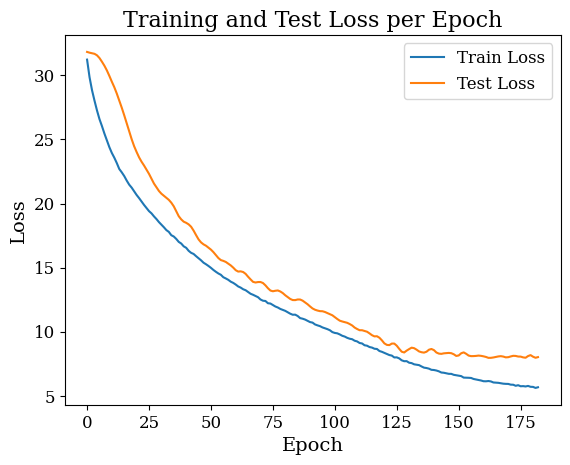

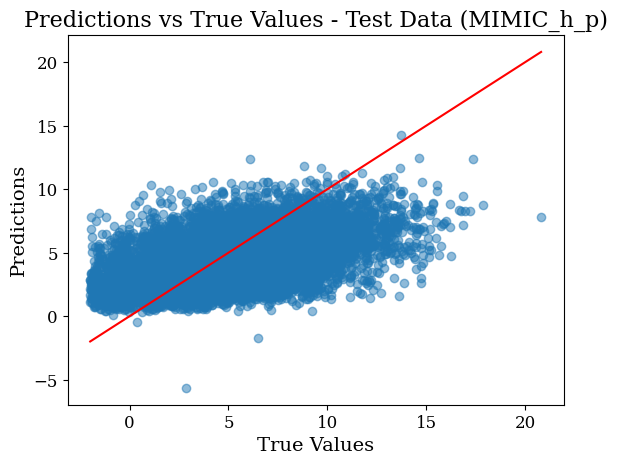

MIMIC_h_p - Training MSE: 4.9495
MIMIC_h_p - Test MSE: 8.0187

Training and evaluating model excluding sensitive attributes (H0)...
Epoch [100/400], Train Loss: 10.9018, Test Loss: 12.1718
Epoch [200/400], Train Loss: 5.6624, Test Loss: 8.0673
Early stopping at epoch 221, Test Loss: 8.1397


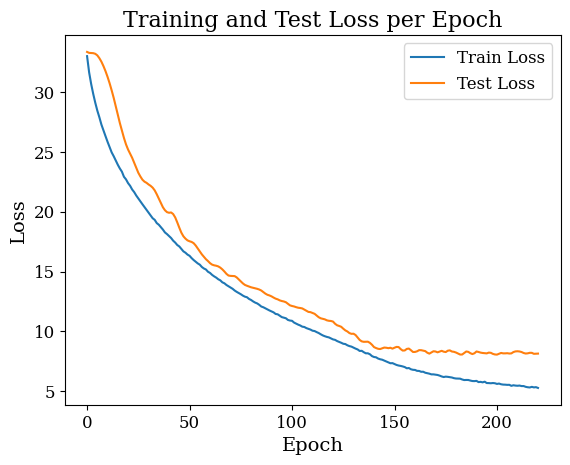

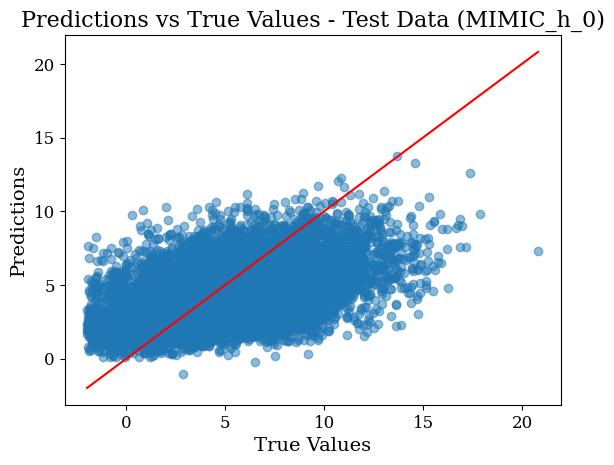

MIMIC_h_0 - Training MSE: 4.4597
MIMIC_h_0 - Test MSE: 8.1397


In [12]:
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model()

For test data:
Number of individuals in 'Female + White':  4111
Number of individuals in 'Female + NonWhite':  1662
Number of individuals in 'Male + White':  5465
Number of individuals in 'Male + NonWhite':  2099

Group-wise Performance Comparison:
--------------------------------------------------------------------------------
Group                Model h_p       Model h_0       Difference     
--------------------------------------------------------------------------------
Female, White                 7.7115          7.7901          0.0785
Female, NonWhite              9.0204          9.0807          0.0602
Male, White                   8.0118          8.2279          0.2161
Male, NonWhite                7.8449          7.8498          0.0050
--------------------------------------------------------------------------------

Overall Performance:
Total loss h_p: 8.0187
Total loss h_0: 8.1397
Total loss difference (h_0 - h_p): 0.1211
For training data:
Number of individuals in 'Female +

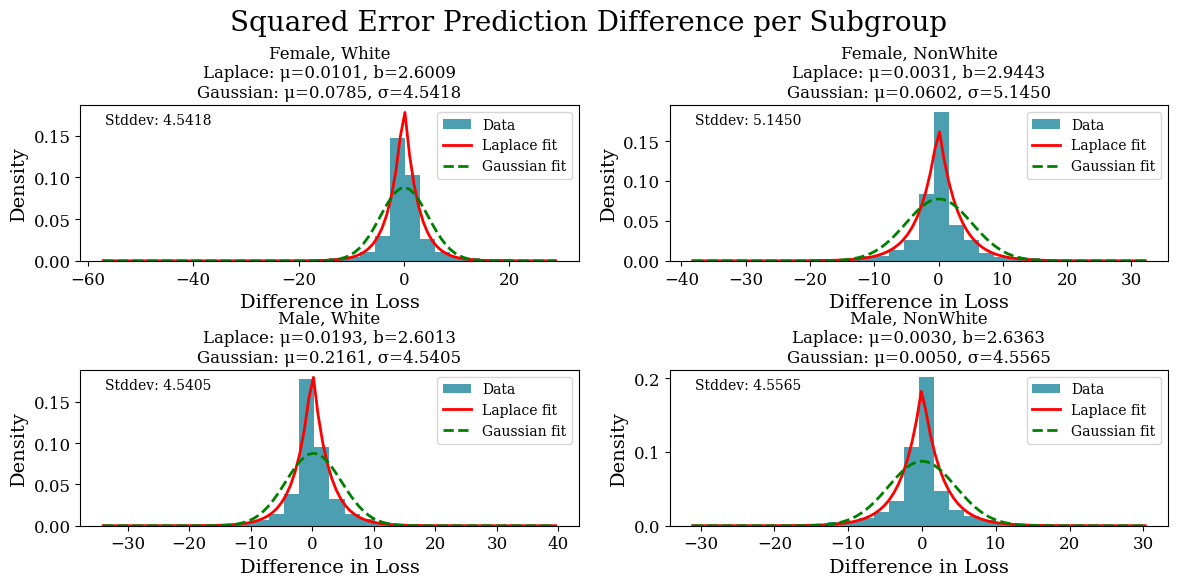

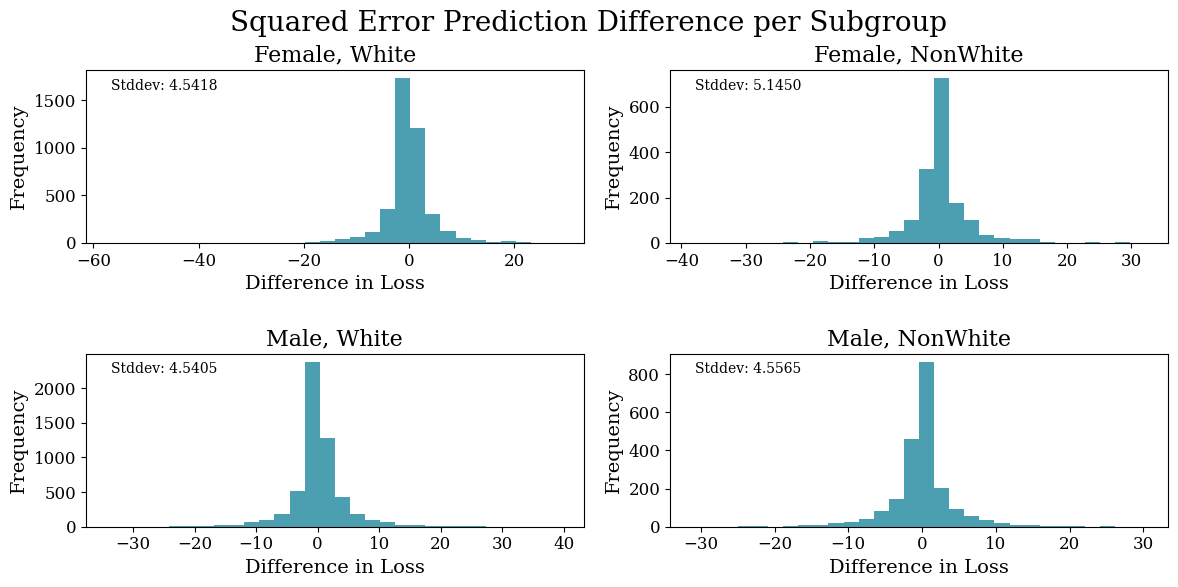

In [13]:
# Step 2: Generate predictions for both models (h_p and h_0)
y_preds_hp = predict_model(model_hp, X_test_hp)  # Using the model trained with all features (h_p)
y_preds_h0 = predict_model(model_h0, X_test_h0)  # Using the model trained excluding gender and race (h_0)

# Use the same true labels for both models
y_test_hp = y_test
y_test_h0 = y_test

# Step 3: Compare models by gender and race using regression cost function (mean squared error)
print("For test data:")
filters = create_gender_race_filters(X_test_hp)
print("Number of individuals in 'Female + White': ", (filters['Female, White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters['Female, NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters['Male, White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters['Male, NonWhite']).sum())

# Compare model performance using the defined filters
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(
    y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, squared_error, comprehensiveness=False
)

print("For training data:")
# Generate predictions for training data
y_preds_hp_train = predict_model(model_hp, X_train_hp)
y_preds_h0_train = predict_model(model_h0, X_train_h0)

# Display number of individuals in each group (based on gender + race)
filters_train = create_gender_race_filters(X_train_hp)
print("Number of individuals in 'Female + White': ", (filters_train['Female, White']).sum())
print("Number of individuals in 'Female + NonWhite': ", (filters_train['Female, NonWhite']).sum())
print("Number of individuals in 'Male + White': ", (filters_train['Male, White']).sum())
print("Number of individuals in 'Male + NonWhite': ", (filters_train['Male, NonWhite']).sum())

# True labels for training data
y_train_hp = y_train
y_train_h0 = y_train

# Compare models for training data
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(
    y_preds_hp_train, y_preds_h0_train, X_train_hp, y_train_hp, y_train_h0, squared_error, comprehensiveness=False
)

# Step 4: Plot loss difference histograms for model predictions using mean squared error
plot_loss_difference_histogram_with_distributions(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, squared_error, "Prediction")
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, squared_error, "Prediction")

In [14]:
# Step 5: Generate explanations with Integrated Gradients for test and training data
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

# Generate explanations for training data
attributions_hp_train, _ = explain_with_ig(model_hp, X_train_hp)
attributions_h0_train, _ = explain_with_ig(model_h0, X_train_h0)

Shape of attributions: torch.Size([13337, 88])
Shape of attributions: torch.Size([13337, 86])
Shape of attributions: torch.Size([31119, 88])
Shape of attributions: torch.Size([31119, 86])


For testing data explainer


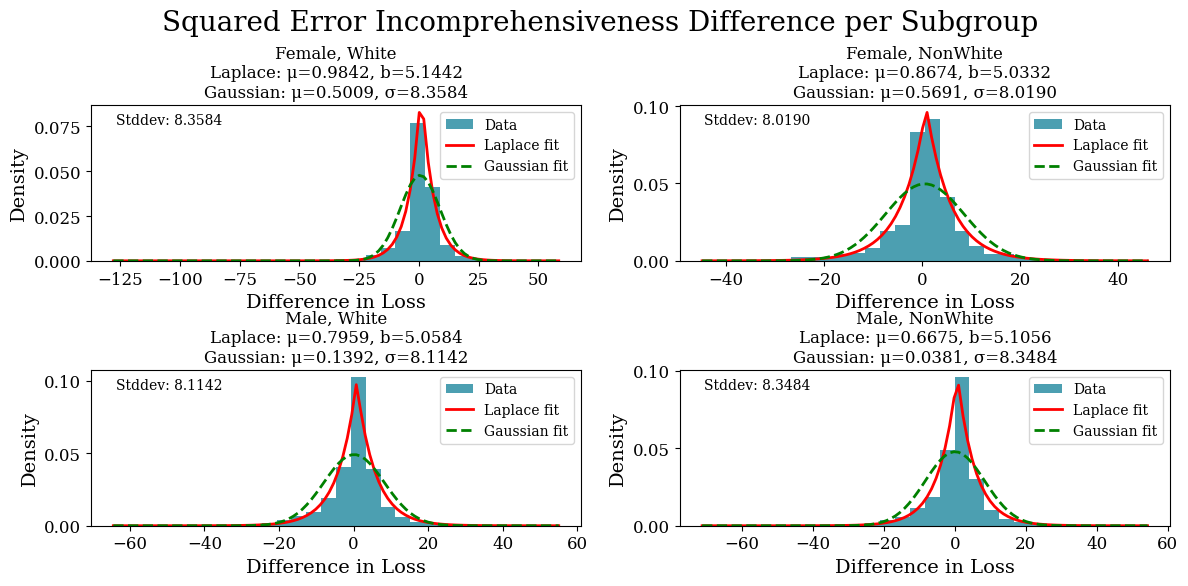

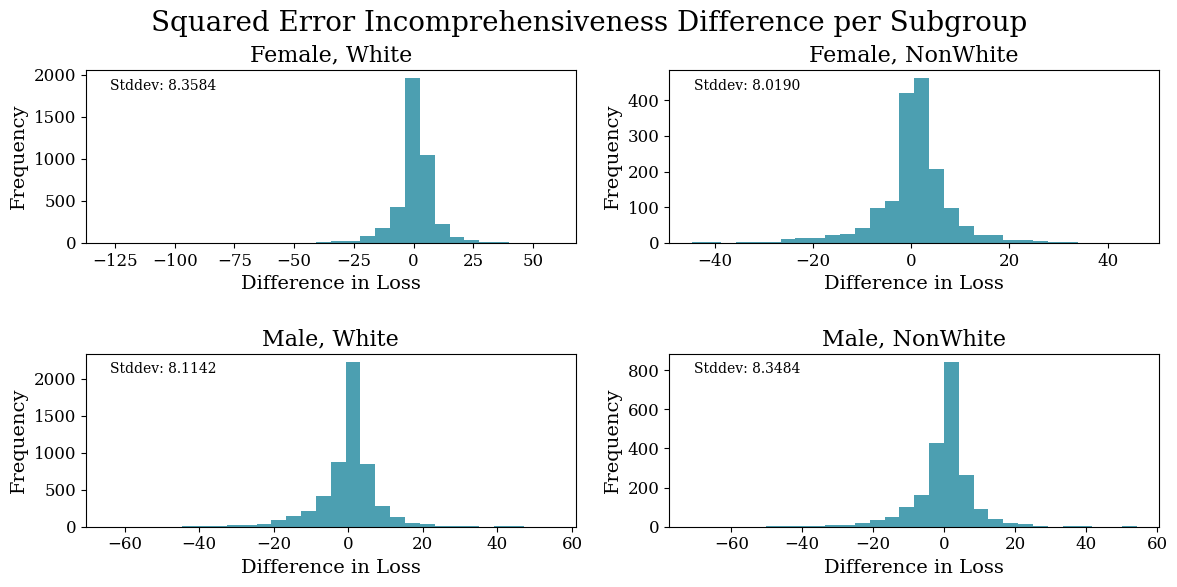


Group-wise Performance Comparison:
--------------------------------------------------------------------------------
Group                Model h_p       Model h_0       Difference     
--------------------------------------------------------------------------------
Female, White               -10.8952        -11.3961         -0.5009
Female, NonWhite            -10.5985        -11.1676         -0.5691
Male, White                 -11.2096        -11.3488         -0.1392
Male, NonWhite              -10.7316        -10.7696         -0.0381
--------------------------------------------------------------------------------

Overall Performance:
Total loss h_p: -10.9613
Total loss h_0: -11.2496
Total loss difference (h_0 - h_p): -0.2884


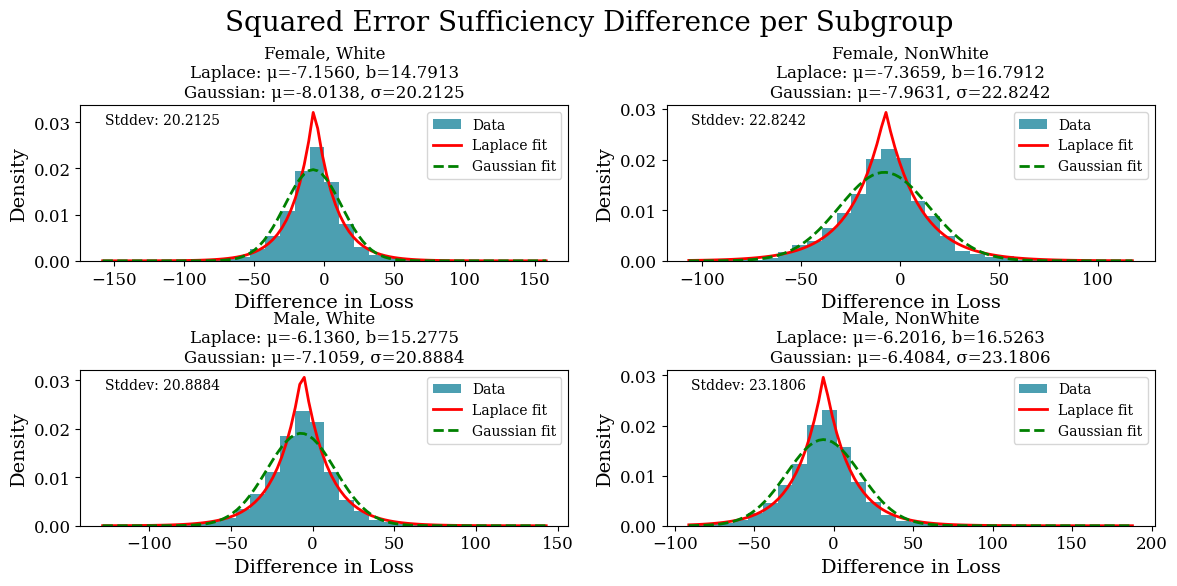

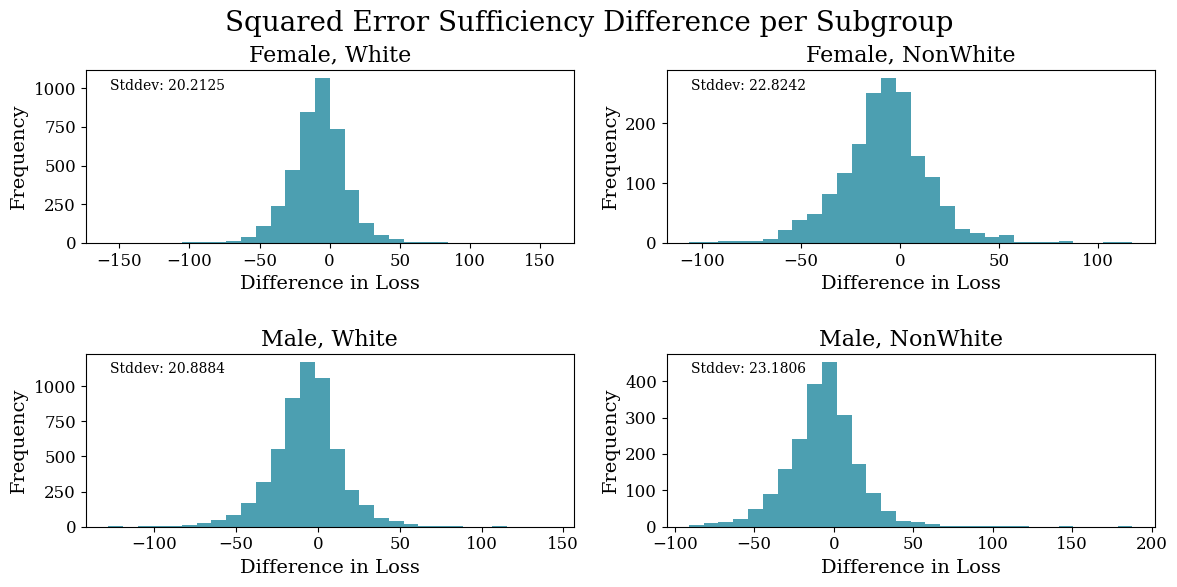


Group-wise Performance Comparison:
--------------------------------------------------------------------------------
Group                Model h_p       Model h_0       Difference     
--------------------------------------------------------------------------------
Female, White                33.1744         25.1606         -8.0138
Female, NonWhite             35.9528         27.9898         -7.9631
Male, White                  33.0193         25.9134         -7.1059
Male, NonWhite               33.4275         27.0191         -6.4084
--------------------------------------------------------------------------------

Overall Performance:
Total loss h_p: 33.4969
Total loss h_0: 26.1141
Total loss difference (h_0 - h_p): -7.3828
For training data explainer

Group-wise Performance Comparison:
--------------------------------------------------------------------------------
Group                Model h_p       Model h_0       Difference     
-------------------------------------------------

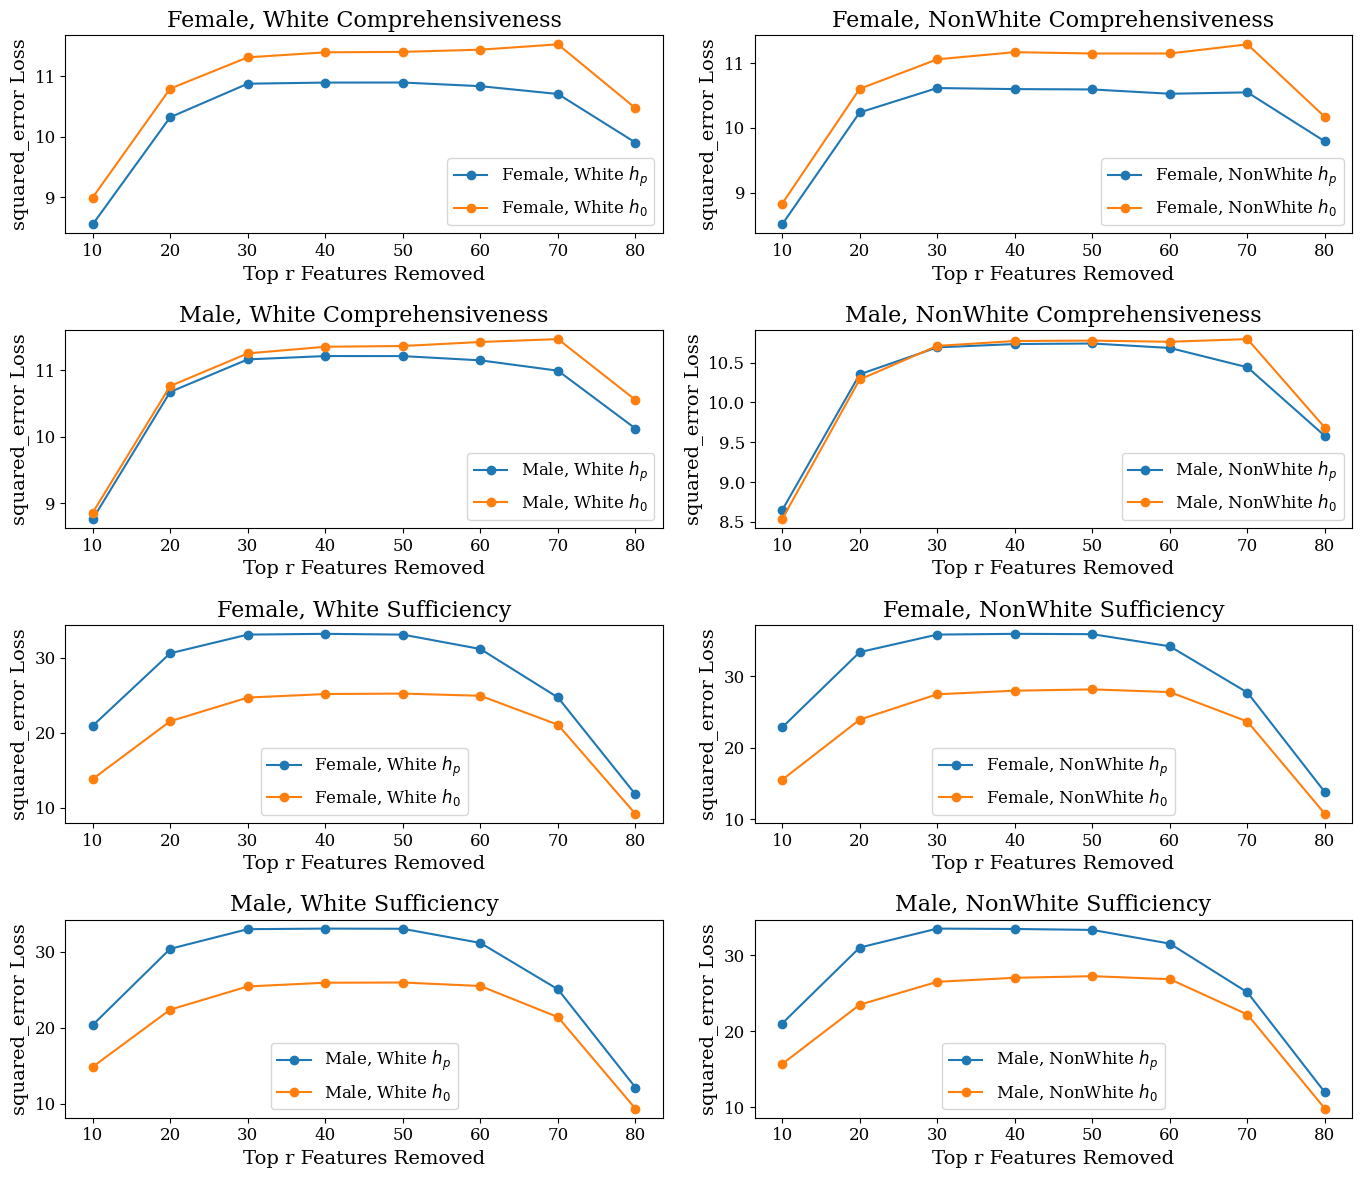

In [15]:
top_k = 40  # Adjust the number of top features to remove

# Step 6: Analyze comprehensiveness for test data
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for comprehensiveness
plot_loss_difference_histogram_with_distributions(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Incomprehensiveness")
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Incomprehensiveness")

# Compare models for comprehensiveness
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp, y_preds_hp, y_preds_h0, squared_error, comprehensiveness=True)

# Step 7: Analyze sufficiency for test data
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for sufficiency
plot_loss_difference_histogram_with_distributions(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Sufficiency")
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Sufficiency")

# Compare models for sufficiency
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, squared_error, comprehensiveness=False)

# Step 8: Analyze comprehensiveness for training data
print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp, X_train_hp, attributions_hp_train, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for comprehensiveness on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp, y_preds_hp_train, y_preds_h0_train, squared_error, comprehensiveness=True)

# Step 9: Analyze sufficiency for training data
sufficiency_preds_hp_train = sufficiency(model_hp, X_train_hp, attributions_hp_train, top_k)
sufficiency_preds_h0_train = sufficiency(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for sufficiency on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(sufficiency_preds_hp_train, sufficiency_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, squared_error, comprehensiveness=False)

# Step 10: Plot loss differences for various values of k
ks = [10, 20, 30, 40, 50, 60, 70, 80]  # Example range of k values
plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, squared_error, ks)

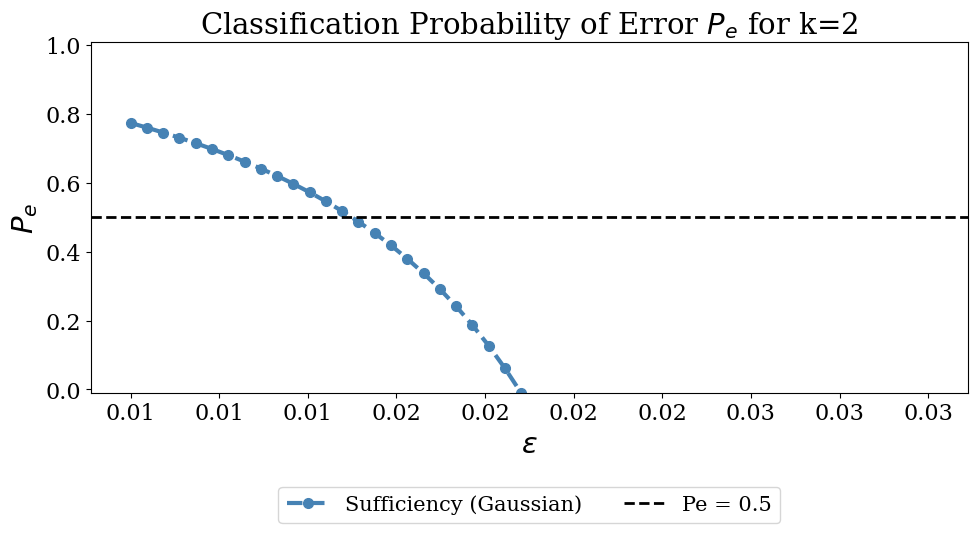

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pe(epsilon, d, m_sigma_pairs):
    # Calculate the inner sum using the new formula
    inner_sum = np.sum([np.exp((m * epsilon**2) / sigma**2) for m, sigma in m_sigma_pairs]) / d
    
    # Calculate the entire expression
    pe = 1 - (1 / (2 * np.sqrt(d))) * (inner_sum - 1)**0.5
    return pe

# Parameters
k = 2
d = 2 ** k

m_sigma_pairs = [(4111, 0.7825), (1662, 0.8775), (5465, 0.7403), (2099, 0.8238)]  # Pairs of m_j and sigma_j
epsilons = np.linspace(0.01, 0.03, 50)  # More granular epsilon values

# Compute P_e for each epsilon
pe_values = [compute_pe(epsilon, d, m_sigma_pairs) for epsilon in epsilons]

# Plot
fontsize = 21
ticksize = 16
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilons, pe_values, label="Sufficiency (Gaussian)", color='steelblue', linewidth=3, linestyle="--", marker='o', markersize=7)

# Add horizontal line at Pe = 0.5 with a label
ax.axhline(y=0.5, c="black", linestyle="--", linewidth=2, label="Pe = 0.5")
ax.set_ylim((-0.01, 1.01))

# Set x-ticks and labels
ax.set_xticks(np.linspace(0.01, 0.03, 10))
ax.set_xticklabels([f"{epsilon:.2f}" for epsilon in np.linspace(0.01, 0.03, 10)])

ax.set_ylabel("$P_{e}$", fontsize=fontsize)
ax.set_xlabel("$\epsilon$", fontsize=fontsize)
ax.set_title(f"Classification Probability of Error $P_{{e}}$ for k={k}", fontsize=fontsize)

# Set the legend at the bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=fontsize-6, frameon=True)

# Set the x and y tick label sizes
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)

plt.tight_layout()
plt.show()

# Save and Load variables

In [17]:
try:
    f.close()
except NameError:
    pass  # File handle 'f' may not exist or may already be closed


for key, value in list(globals().items()):
    if not key.startswith("__"):
        try:
            pickle.dumps({key: value})
        except Exception as e:
            print(f"Cannot pickle {key}: {e}")

# Explicitly exclude problematic keys like 'f' and others
excluded_keys = {'f', 'variables_to_save', 'get_ipython', 'exit', 'quit', 'open', 'pd', 'np', 'torch', 'nn', 'optim', 'plt', 'stats', 'pickle', 'types', 'io'}

# Filter globals
variables_to_save = {
    key: value for key, value in globals().items()
    if key not in excluded_keys  # Exclude known problematic variables
    and not key.startswith("__")  # Exclude built-ins
    and not isinstance(value, types.ModuleType)  # Exclude modules
    and not isinstance(value, types.FunctionType)  # Exclude functions
    and not isinstance(value, io.IOBase)  # Exclude open file handles
}

print("Variables being saved:", list(variables_to_save.keys()))

# Save the filtered variables
with open('variables_regression.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)

Cannot pickle get_ipython: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle exit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle quit: Can't pickle local object 'ScriptMagics._make_script_magic.<locals>.named_script_magic'
Cannot pickle open: Can't pickle <function open at 0x7f4d9428d620>: it's not the same object as io.open
Cannot pickle pd: cannot pickle 'module' object
Cannot pickle np: cannot pickle 'module' object
Cannot pickle torch: cannot pickle 'module' object
Cannot pickle nn: cannot pickle 'module' object
Cannot pickle optim: cannot pickle 'module' object
Cannot pickle plt: cannot pickle 'module' object
Cannot pickle pickle: cannot pickle 'module' object
Cannot pickle types: cannot pickle 'module' object
Cannot pickle io: cannot pickle 'module' object
Cannot pickle stats: cannot pickle 'module' object
Variables being saved: ['_ih', '_oh', '_dh', 'In', 'Out', '_', '_i',

In [18]:
# Load the variables
with open('variables_regression.pkl', 'rb') as f:
    loaded_variables = pickle.load(f)

# Update globals with loaded variables
globals().update(loaded_variables)
print("Variables loaded:", list(loaded_variables.keys()))

Variables loaded: ['_ih', '_oh', '_dh', 'In', 'Out', '_', '_i', '_ii', '_iii', '_i1', 'KNNImputer', 'StandardScaler', 'MinMaxScaler', 'IntegratedGradients', '_i2', 'X_all', 'X_without_sensitive', 'y', '_i3', '_3', '_i4', 'DeeperNNWithBatchNorm', '_i5', '_i6', '_i7', '_i8', '_i9', '_i10', '_i11', '_i12', 'X_train_hp', 'X_test_hp', 'y_train', 'y_test', 'X_train_h0', 'X_test_h0', 'model_hp', 'model_h0', '_i13', 'y_preds_hp', 'y_preds_h0', 'y_test_hp', 'y_test_h0', 'filters', 'group_losses_hp', 'group_losses_h0', 'y_preds_hp_train', 'y_preds_h0_train', 'filters_train', 'y_train_hp', 'y_train_h0', 'group_losses_hp_train', 'group_losses_h0_train', '_i14', 'attributions_hp', 'attributions_h0', 'attributions_hp_train', 'attributions_h0_train', '_i15', 'top_k', 'comprehensiveness_preds_hp_reg', 'comprehensiveness_preds_h0_reg', 'sufficiency_preds_hp', 'sufficiency_preds_h0', 'comprehensiveness_preds_hp_train_reg', 'comprehensiveness_preds_h0_train_reg', 'sufficiency_preds_hp_train', 'sufficienc